In [2]:
import pandas as pd
import numpy as np
import sys

from kornmo import KornmoDataset
from geodata import get_farmer_elevation
from kornmo import kornmo_utils as ku
from frostdataset import FrostDataset

%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def filter_by_years(years, data):
    return data[data['year'].isin(years)]

def get_interpolated_data(years, weather_feature):
    data = pd.DataFrame()

    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'data/frost/nn_interpolated/{weather_feature}/{weather_feature}_interpolated_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    # Drop columns containing 'Unnamed'
    data.drop(columns=[col for col in data.columns if 'Unnamed' in col], inplace=True)

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year', 'longitude', 'latitude', 'elevation']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])

    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

def get_proximity_data(years, weather_feature):
    data = pd.DataFrame()
    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'data/frost/by_proximity/{weather_feature}/{weather_feature}_by_proximity_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.drop(columns=['ws_id'], inplace=True)
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])


    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

In [4]:
years = [2017, 2018, 2019]
frost = FrostDataset()
kornmo = KornmoDataset()
deliveries = kornmo.get_deliveries().pipe(ku.split_farmers_on_type)

elevation_data = get_farmer_elevation()
deliveries = deliveries.merge(elevation_data, on=['orgnr'], how='left').fillna(0)

deliveries["yield"] = ku.normalize(deliveries["levert"]/deliveries["areal"], 0, 1000)
deliveries["areal"] = ku.normalize(deliveries["areal"])
deliveries['fulldyrket'] = ku.normalize(deliveries['fulldyrket'])
deliveries['overflatedyrket'] = ku.normalize(deliveries['overflatedyrket'])
deliveries['tilskudd_dyr'] = ku.normalize(deliveries['tilskudd_dyr'])
deliveries['lat'] = ku.normalize(deliveries['lat'])
deliveries['elevation'] = ku.normalize(deliveries['elevation'])

deliveries["key"] = deliveries.orgnr.astype(str) + "/" + deliveries.year.astype(str)
deliveries = deliveries.set_index("key")
deliveries = filter_by_years(years, deliveries)

deliveries

Loading deliveries...
Number of deliveries loaded: 78290


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,areal,bygg,havre,hvete,rug_og_rughvete,lat,elevation,yield
key,,,,,,,,,,,,,,,,,,
811555762/2017,2017,811555762,1653,24,2,0,0.007674,0.0,0.000000,17067,0.017179,1.0,0.0,0.0,0.0,0.959116,0.051198,0.289271
811580082/2017,2017,811580082,1124,25,5,0,0.117186,0.0,0.344044,81204,0.064195,1.0,0.0,0.0,0.0,0.891830,0.024510,0.377693
811675792/2017,2017,811675792,709,2023,12,0,0.015028,0.0,0.000000,10902,0.020494,1.0,0.0,0.0,0.0,0.896483,0.014706,0.155743
811675792/2017,2017,811675792,709,2023,12,0,0.015028,0.0,0.000000,2335,0.003918,0.0,0.0,1.0,0.0,0.896483,0.014706,0.155667
811935662/2017,2017,811935662,125,207,1,0,0.015188,0.0,0.000000,33166,0.031344,0.0,0.0,1.0,0.0,0.907412,0.073529,0.312887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999659209/2019,2019,999659209,811,31,64,0,0.014548,0.0,0.000000,13426,0.017782,1.0,0.0,0.0,0.0,0.898225,0.068627,0.220098
999662730/2019,2019,999662730,715,247,1,0,0.046523,0.0,0.000000,86888,0.052743,0.0,1.0,0.0,0.0,0.902149,0.093137,0.490893
999662730/2019,2019,999662730,715,247,1,0,0.046523,0.0,0.000000,44841,0.035564,0.0,0.0,1.0,0.0,0.902149,0.093137,0.373675


In [5]:
historical = ku.get_historical_production(kornmo, deliveries.year.unique(), 4)
historical = deliveries.merge(historical, how='left').fillna(0)
historical["key"] = historical.orgnr.astype(str) + "/" + historical.year.astype(str)
historical = historical.drop(columns=deliveries.columns)
historical = historical.drop_duplicates(subset='key')
historical = historical.set_index("key")
#historical = filter_by_years(years, historical)

historical

Loading historical grants data...
Historical data loaded for years 2013 to 2019.


D:\OneDrive - Universitetet i Agder\Master Thesis\kornmo-master-thesis\kornmo\kornmo_utils.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(history_data, ignore_index=True)
D:\OneDrive - Universitetet i Agder\Master Thesis\kornmo-master-thesis\kornmo\kornmo_utils.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(history_data, ignore_index=True)
D:\OneDrive - Universitetet i Agder\Master Thesis\kornmo-master-thesis\kornmo\kornmo_utils.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(history_data, ignore_index=True)


,bygg_sum_0,hvete_sum_0,havre_sum_0,rug_og_rughvete_sum_0,bygg_sum_1,hvete_sum_1,havre_sum_1,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3
key,,,,,,,,,,,,,,,,
811555762/2017,1.3687,0.0000,0.0000,0.0,2.2050,0.0000,0.0000,0.0,2.0620,0.0000,0.0000,0.0,2.2445,0.0000,0.0000,0.0
811580082/2017,2.9200,0.0000,0.0000,0.0,4.7596,0.0000,0.0000,0.0,6.4999,0.0000,0.0000,0.0,11.7227,0.0000,0.0000,0.0
811675792/2017,0.0000,0.0000,0.0000,0.0,0.0000,2.8870,0.6015,0.0,0.0000,1.4844,0.2770,0.0,0.0000,2.2717,0.4869,0.0
811935662/2017,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,1.0643,2.5620,0.0000,0.0
812075322/2017,1.7688,0.4413,0.0000,0.0,3.3676,0.0000,0.0000,0.0,1.7060,1.4768,0.0000,0.0,2.2838,1.0750,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999640001/2019,0.0000,21.5508,4.7821,0.0,14.6406,0.0000,4.8990,0.0,9.4914,33.1335,5.0059,0.0,8.4269,6.3109,0.0000,0.0
999659209/2019,0.0000,2.2603,0.0000,0.0,1.8102,0.0000,0.0000,0.0,0.0000,1.1576,0.0000,0.0,0.0000,0.0000,1.5396,0.0
999662730/2019,0.0000,5.1119,9.7433,0.0,0.0000,2.9122,10.4515,0.0,0.0000,4.7917,8.2873,0.0,0.0000,1.8919,5.8078,0.0


In [6]:
sunlight_data = get_interpolated_data(years, 'sunlight')
daydegree5_data = get_interpolated_data(years, 'daydegree5').drop(columns=['longitude', 'latitude', 'elevation'])
ground_data = get_proximity_data(years, 'ground')
temp_and_precip_data = frost.get_as_aggregated(1).dropna().astype(float)
weather_data = temp_and_precip_data.merge(sunlight_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(daydegree5_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(ground_data, how='left', on=['orgnr', 'year'])

print(f"Merged {temp_and_precip_data.shape[1]} features of temp and precip data, {sunlight_data.shape[1]} features of sunlight data, {daydegree5_data.shape[1]} features of daydegree data, {ground_data.shape[1]} features of ground data to a total of {weather_data.shape[1]} features")

#weather_data = frost.get_as_aggregated(1).dropna().astype(float)

weather_data["key"] = weather_data.orgnr.astype(int).astype(str) + "/" + weather_data.year.astype(int).astype(str)
weather_data.drop(columns=["year", "orgnr"], inplace=True)
weather_data = weather_data.drop_duplicates(subset=["key"])
weather_data = weather_data.set_index("key")
weather_data

Loading sunlight data...
Number of loaded entries: 30462
Loading daydegree5 data...
Number of loaded entries: 30462
Loading ground data...
Number of loaded entries: 30462
Loading weather data...


D:\OneDrive - Universitetet i Agder\Master Thesis\kornmo-master-thesis\kornmo\frostdataset.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_data = weather_data.append(weather, ignore_index=True)
D:\OneDrive - Universitetet i Agder\Master Thesis\kornmo-master-thesis\kornmo\frostdataset.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_data = weather_data.append(weather, ignore_index=True)
D:\OneDrive - Universitetet i Agder\Master Thesis\kornmo-master-thesis\kornmo\frostdataset.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_data = weather_data.append(weather, ignore_index=True)


Weather data entries loaded: 33003
Merged 859 features of temp and precip data, 219 features of sunlight data, 216 features of daydegree data, 216 features of ground data to a total of 1504 features


,growth_start_day,min_temp0,min_temp1,min_temp2,min_temp3,min_temp4,min_temp5,min_temp6,min_temp7,min_temp8,...,day_204,day_205,day_206,day_207,day_208,day_209,day_210,day_211,day_212,day_213
key,,,,,,,,,,,,,,,,,,,,,
811555762/2017,0.061905,0.491667,0.411667,0.421667,0.496667,0.486667,0.448333,0.391667,0.361667,0.406667,...,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
811580082/2017,0.038095,0.505000,0.521667,0.560000,0.543333,0.526667,0.473333,0.413333,0.446667,0.560000,...,0.285714,0.00,0.125,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222
811675792/2017,0.114286,0.485000,0.435000,0.503333,0.500000,0.450000,0.430000,0.390000,0.300000,0.490000,...,0.142857,0.25,0.125,0.111111,0.142857,0.142857,0.285714,0.111111,0.000000,0.111111
811935662/2017,0.114286,0.491667,0.465000,0.473333,0.466667,0.438333,0.406667,0.370000,0.411667,0.488333,...,0.142857,0.00,0.125,0.111111,0.285714,0.142857,0.142857,0.111111,0.000000,0.000000
812075322/2017,0.114286,0.458333,0.400000,0.440000,0.458333,0.430000,0.410000,0.398333,0.300000,0.440000,...,0.285714,0.50,0.125,0.222222,0.285714,0.285714,0.285714,0.222222,0.000000,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997229789/2019,0.219048,0.456667,0.445000,0.423333,0.341667,0.291667,0.281667,0.326667,0.396667,0.386667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997237269/2019,0.233333,0.418333,0.371667,0.486667,0.481667,0.415000,0.421667,0.453333,0.358333,0.320000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997365747/2019,0.219048,0.405000,0.401667,0.388333,0.216667,0.181667,0.143333,0.296667,0.383333,0.270000,...,0.285714,0.50,0.125,0.111111,0.142857,0.142857,0.142857,0.111111,0.111111,0.111111


In [7]:
#Combine dataset

# sat_img_path = 'C:/'
# from sentinel.storage import SentinelDataset
# print("Reading sentinel_100x100_0.h5")
# ds0 = SentinelDataset(f"{sat_img_path}/sentinel_100x100_0.h5")
# print("Reading sentinel_100x100_1.h5")
# ds1 = SentinelDataset(f"{sat_img_path}/sentinel_100x100_1.h5")
# print("Combining both")
# SentinelDataset.combine_datasets([ds0, ds1], "E:/combined_compressed.h5", compression=4)

In [ ]:
from kornmo.sentinel.storage import SentinelDataset
sat_img_path = 'E:/MasterThesisData/Satellite_Images'
sd = SentinelDataset(f"{sat_img_path}/sentinel_images_combined_uncompressed_100x100.h5")
train, val = sd.to_iterator().split(rand_seed='abc')

def add_historical(orgnr, year, data):
    if f"{orgnr}/{year}" in historical.index.values:
        h_data = historical.loc[f"{orgnr}/{year}"]
        return {'historical': h_data.values }
    else:
        return []
def add_weather(orgnr, year, data):
    if f"{orgnr}/{year}" not in weather_data.index:
        return []
    wd = weather_data.loc[f"{orgnr}/{year}"]
    # min_temps = [value for key, value in wd.items() if key.startswith("min_temp")]
    # mean_temps = [value for key, value in wd.items() if key.startswith("mean_temp")]
    # max_temps = [value for key, value in wd.items() if key.startswith("max_temp")]
    # total_rain = [value for key, value in wd.items() if key.startswith("total_rain")]
    # stacked = np.stack((min_temps, mean_temps, max_temps, total_rain), axis=1)

    return { 'weather': wd.values }

def add_grain_types(orgnr, year, data):
    samples = deliveries.loc[[f"{orgnr}/{year}"]]

    all_grains = []
    for _, row in samples.iterrows():
        sample = {}
        if row.bygg: sample["type"] = (1,0,0,0)
        elif row.havre: sample["type"] = (0,1,0,0)
        elif row.rug_og_rughvete: sample["type"] = (0,0,1,0)
        elif row.hvete: sample["type"] = (0,0,0,1)

        sample["areal"] = row["areal"]
        sample["lat"] = row["lat"]
        sample["elevation"] = row["elevation"]
        sample["yield"] = row["yield"]
        sample['fulldyrket'] = row['fulldyrket']
        sample['overflatedyrket'] = row['overflatedyrket']
        sample['tilskudd_dyr'] = row['tilskudd_dyr']
        all_grains.append(sample)

    return all_grains

train = train.with_data(add_historical, True)\
             .with_data(add_weather, True)\
             .with_data(add_grain_types, True)

val = val.with_data(add_historical, True)\
         .with_data(add_weather, True)\
         .with_data(add_grain_types, True)

#13597
#13582
#12876
#3400
#3395
#3182

In [9]:
import h5py
with h5py.File('data/masks/nibio_disposed_properties_masks.h5', "r+") as out_file:
    print(out_file['masks']['811555762'].keys())

<KeysViewHDF5 ['2017', '2018', '2019']>


In [10]:
from kornmo.mask.mask_dataset import MaskDataset
from kornmo.mask.utils import add_mask_as_channel, apply_mask_to_image_series

mask_dataset_path = "Edata/masks/nibio_disposed_properties_masks.h5"
mask_dataset = MaskDataset(mask_dataset_path)
#print(mask_dataset.labels)

mask_iterator = mask_dataset.get_iterator()
mask_dict = {}
for orgnr, year, mask in mask_iterator:
    mask_dict[f'{orgnr}/{year}'] = mask

def apply_mask(orgnr, year, imgs):
    mask = mask_dict[f'{orgnr}/{year}']
    return apply_mask_to_image_series(mask, imgs)

train = train.filter(lambda orgnr, year, _,__: f"{orgnr}/{year}" in mask_dict)
val = val.filter(lambda orgnr, year, _,__: f"{orgnr}/{year}" in mask_dict)

print(f"train samples: {len(train)}")
print(f"val samples: {len(val)}")
#19003
#4706

train samples: 19004
val samples: 4710


In [11]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
# from tensorflow.data.experimental import assert_cardinality
from kornmo.sentinel.transform import salt_n_pepper, rotate180, rotate90

stride = 10
def top_left(imgs):
    return imgs[...,:-stride, :-stride,:]
def top_right(imgs):
    return imgs[...,:-stride, stride:,:]
def bot_left(imgs):
    return imgs[...,stride:, :-stride,:]
def bot_right(imgs):
    return imgs[...,stride:, stride:,:]
def center(imgs):
    s = stride//2
    return imgs[...,s:-s, s:-s,:]

def rotate_random(imgs):
    angle = np.random.rand(30) * 6.28
    return tfa.image.rotate(imgs, angle)

augmented_dataset = train\
    .transform(apply_mask)\
    .transform(salt_n_pepper())\
    .augment([center, top_left, top_right, bot_left, bot_right], keep_original=False)\
    .transform(rotate_random)

def apply_output(orgnr, year, img_source, data):
    features = data["areal"], *data["type"]
    output = data["yield"]
    weather = data["weather"][1:]
    return {"cnn_input": img_source[0:30], "feature_input": features, "weather_input": weather}, output

train_dataset = tf.data.Dataset.from_generator(
    augmented_dataset.apply(apply_output).shuffled(),
    output_types=({"cnn_input": tf.dtypes.float64, "feature_input": tf.dtypes.float64, "weather_input": tf.dtypes.float64}, tf.dtypes.float64),
).apply(tf.data.experimental.assert_cardinality(len(augmented_dataset)))

val_dataset = tf.data.Dataset.from_generator(
    val.transform(apply_mask).transform(center).apply(apply_output),
    output_types=({"cnn_input": tf.dtypes.float64, "feature_input": tf.dtypes.float64, "weather_input": tf.dtypes.float64}, tf.dtypes.float64),
).apply(tf.data.experimental.assert_cardinality(len(val)))

print(f"Augmented samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
#95015
#4706

Augmented samples: 95020
Validation samples: 4710


In [15]:
from keras import layers, models
from keras.models import Sequential, load_model
from tensorflow import keras



def CNN(input_dim, output_dim):
    input_layer = layers.Input(shape=input_dim)
    y = layers.Conv2D(16, (3, 3), activation=tf.nn.relu, padding='same')(input_layer)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(y)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(y)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Flatten()(y)
    y = layers.Dense(output_dim, activation=tf.nn.relu)(y)

    return models.Model(inputs=[input_layer], outputs=[y], name="SingleImageCNN")

model_checkpoint = keras.callbacks.ModelCheckpoint(
    './training',
    monitor="val_loss",
    verbose=0,
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

callbacks = [callback, model_checkpoint]

restart = True
if restart:

    scnn = CNN((90, 90, 12), 64)
    #scnn.summary(line_length=130)
    input_weather = layers.Input(shape=1501, name="weather_input") #shape = 856 / 1501
    t_wm = layers.Reshape((19, 79))(input_weather) # (4, 214) / (19, 79)
    t_wm = layers.Permute((2, 1))(t_wm)
    t_wm = layers.Conv1D(64, 50, activation=tf.nn.relu)(t_wm) # (64, 7, 7) / (64, 50)

    input_cnn = layers.Input(shape=(30, 90, 90, 12), name="cnn_input")

    feature_input = layers.Input(shape=(5,), name="feature_input")
    feature_repeated = layers.RepeatVector(30)(feature_input)

    cnn = layers.TimeDistributed(scnn)(input_cnn)
    cnn = layers.Concatenate(axis=2)([cnn, feature_repeated, t_wm])
    cnn = layers.GRU(128, return_sequences=False)(cnn)
    cnn = layers.Flatten()(cnn)
    cnn = layers.Dense(128, activation=tf.nn.relu)(cnn)
    cnn = layers.Dense(1)(cnn)

    cnn = models.Model(inputs=[input_weather, input_cnn, feature_input], outputs=cnn, name="CNN")
    #cnn.summary(line_length=130)

    cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')

    cnn_history = cnn.fit(
        train_dataset.take(10000).batch(32).prefetch(2),
        validation_data=val_dataset.batch(32).prefetch(2),
        epochs=70,
        verbose=1,
        callbacks=callbacks
    )

else:
    cnn = load_model('./training/epoch_2.hdf5')
    # update the learning rate
    cnn_history = cnn.fit(
        train_dataset.take(10000).batch(32).prefetch(2),
        validation_data=val_dataset.batch(32).prefetch(2),
        epochs=10,
        verbose=1,
        callbacks=callbacks
    )

Epoch 1/70
313/313 [==============================] - 4988s 16s/step - loss: 0.1307 - val_loss: 0.1065
Epoch 2/70
313/313 [==============================] - 4615s 15s/step - loss: 0.1107 - val_loss: 0.1136
Epoch 3/70
313/313 [==============================] - 4458s 14s/step - loss: 0.1042 - val_loss: 0.1152
Epoch 4/70
313/313 [==============================] - 4592s 15s/step - loss: 0.1025 - val_loss: 0.1045
Epoch 5/70
313/313 [==============================] - 4665s 15s/step - loss: 0.1040 - val_loss: 0.0989
Epoch 6/70
313/313 [==============================] - 4644s 15s/step - loss: 0.0989 - val_loss: 0.1015
Epoch 7/70
313/313 [==============================] - 4659s 15s/step - loss: 0.0985 - val_loss: 0.1005
Epoch 8/70
313/313 [==============================] - 4476s 14s/step - loss: 0.0961 - val_loss: 0.0937
Epoch 9/70
313/313 [==============================] - 4030s 13s/step - loss: 0.0958 - val_loss: 0.0952
Epoch 10/70
313/313 [==============================] - 4014s 13s/step - l

Denormalized MAE: 78.96059544402297


'\n# loss = []\n# val_loss = []\n\n\nsns.set_style(\'whitegrid\')\nsns.set_context("paper")\n\nplt.xlabel(\'Epoch\')\nplt.ylabel("Loss")\nplt.plot(loss, label="loss")\nplt.plot(val_loss, label="val_loss")\nplt.legend()\nplt.title("Mean absolute error loss")\nplt.savefig(f\'E:/MasterThesisData/models/hybrid_more_features.png\', dpi=600)\nplt.grid()\n'

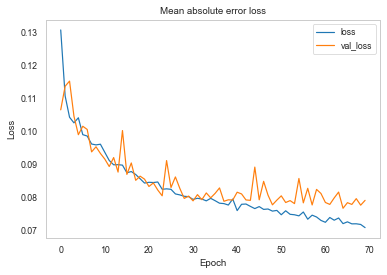

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


def denormalize(df, lower: float, upper: float):
    """
    Denormalizes DataFrame
    :param df: The DataFrame where all columns will be denormalized.
    :param lower: The denormalized value of 0
    :param upper: The denormalized value of 1
    :return: The denormalized DataFrame
    """

    return df * (upper - lower) + lower


def plot_history(history, save_file: str=None):
    sns.set_style('whitegrid')
    sns.set_context("paper")

    plt.xlabel('Epoch')
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="loss")
    plt.plot(history.history['val_loss'], label="val_loss")
    plt.legend()
    plt.title("Mean absolute error loss")
    if save_file is not None:
        plt.savefig(save_file, dpi=600)
    plt.grid()


plot_history(cnn_history, save_file="E:/MasterThesisData/models/hybrid_more_features_history.png")


predictions = cnn.predict(val_dataset.batch(32).prefetch(2))
predictions = np.array(predictions).flatten()
facts = val.apply(lambda orgnr, year, img, data: data["yield"]).as_array()
absolute_error = np.abs(predictions - facts)
print(f"Denormalized MAE: {denormalize(absolute_error.mean(), 0, 1000)}")


